In [11]:
import requests
import time
import os
from elasticsearch import helpers, Elasticsearch
from collections import defaultdict
import csv
import gzip
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Data Pipeline
## 1. Data Retrieval
According to IMDB documentation, the datasets are updated once a day. Therefore a batch download of the dataset once a day is sufficient.
This can be done with a background script that is running the below code in a server. (ex: use *cron* or python *schedule* library) 

The code is designed to treat the links to the datasets as APIs. I.e. a GET request to each dataset is called on a daily basis. This assumes a certain ammount of reliability form IMDB. 

*(The alternative is to scrape the website itself which is trivial with the current state of the site but is definitely not as robust as the above approach)*

Key points:
 -  The data is kept as compressed for deep storage and not overwritten. This is useful for version controls especially since IMDB does not offer this.
 - If failure to connect to IMDB, the below code retires 5 times with a time delay.
 - If attempts have been exhausted, a notification should be sent as a fallback for engineers to resolve any issues.


In [2]:
datasets = ['https://datasets.imdbws.com/name.basics.tsv.gz',
            'https://datasets.imdbws.com/title.akas.tsv.gz',
            'https://datasets.imdbws.com/title.basics.tsv.gz',
            'https://datasets.imdbws.com/title.crew.tsv.gz',
            'https://datasets.imdbws.com/title.episode.tsv.gz',
            'https://datasets.imdbws.com/title.principals.tsv.gz',
            'https://datasets.imdbws.com/title.ratings.tsv.gz']

In [ ]:
# This code block should be run once a day in an automated process
attempts = 5
for attempt in range(attempts):
    try:
        # Create subdirectory to save today's data in
        timestr = time.strftime("%Y%m%d")
        if not os.path.exists(timestr):
            os.makedirs(timestr)
    
        # Download data files to storage
        for link in datasets:
            file = requests.get(link)
            # Save to directory
            with open(os.path.join(timestr, link.split("/")[-1]), "wb") as fz:
                fz.write(file.content)
                
    except requests.exceptions.RequestException as e:
        raise e
        # wait 2 minutes before retry
        time.sleep(120)
        
        if attempt == attempts - 1:
            # Notify admins/engineers that data retrieval for the day was skipped.
            pass
        
        continue
        
    print("success")
    break

## 2. Cleaning and Building indices

Compressed data in a server is not useful to anyone. The next step in the data pipeline is to make the data easily accessible both for analytics and for product integration purposes. The below code can also be run once a day after step 1.

### A. Cleaning data

The IMDB data contains `\N` for null value. For elasticsearch this is problematic for some ES types since in order for ES to recognise null values they have to be in the same mapping type of their corresponding field. For example: `\N` in the `startYear` field can be turned to `0000` (`Date` field that will not be used by any record). Other cleaning issues like empty fields should also be taken care of.

The below is an example of this data cleaning on two of the downloaded datasets:

In [ ]:
# Load the two main datasets for cleaning
basics = pd.read_csv(datasets[2], compression='gzip', header=0, sep='\t')
akas = pd.read_csv(datasets[1], compression='gzip', header=0, sep="\t")

In [ ]:
basics['endYear'] = basics['endYear'].replace('\\N', '0000')
basics['startYear'] = basics['startYear'].replace('\\N', '0000')
basics['runtimeMinutes'] = basics['runtimeMinutes'].replace('\\N', -1)
# Fill empty value with IMDB's default "null"
akas['region'] = akas['region'].fillna("\\N")
akas['title'] = akas['title'].fillna("\\N")

# use the same dataset names to store the cleaned datasets
basics.to_csv(datasets[2].split("/")[-1], index=False, sep="\t")
akas.to_csv(datasets[1].split("/")[-1], index=False, sep="\t")

### B. Denormalising data

 - The downloaded data is heavily normalised, a significant drawback of this is expensive queries. 
  - By using nested objects in elasticsearch, there is only need for one index to be built and therefore queries and analytics become much more efficient.
  
  
### C. Building indices
The indices for the IMDB datasets can be automatically built/updated once a day after the retrieval. The below code is indexing a subset of the datasets (title.basics with title.akas as nested objects).
 - This can be done on a daily basis in an automated proces including all the other datasets

#### Performance notes:
 - The size of each dataset should be noted in order to set the number of `shards` if needed (for performance).
 - In a cluster it is a good idea to use `replicas` (faster search and robust against down time).

In [3]:
# Initialise elasticsearch server
es = Elasticsearch(host='localhost', port=9200)

In [ ]:
# this make a list of dataframes, one for each unique titleId
akas_groups = akas.groupby('titleId')

In [ ]:
def get_data(path, akas_groups):
    # Open file into a DictReader object
    with gzip.open(path, "rt", encoding='UTF-8') as f:
        reader = csv.DictReader(f, delimiter='\t')
        for row in reader:
            # add the aka data as nested object in the current row
            if row['tconst'] in akas_groups.groups.keys():
                titleId_akas = akas_groups.get_group(row['tconst']).iloc[:, 1:]
                row['akas'] = titleId_akas.to_dict(orient='list')
            else:
                row['akas'] = {}
            # return reader generator object
            yield {"_source":row}

In [ ]:
# The below code can be replicated for the rest of the datasets in order to have a set of indices.
directory = "20201119/title.basics.tsv.gz"
index_name = "title"

# Load corresponding mapping and create index if not already created
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body=json.load(open("mappings/title_mappings.json")))

helpers.bulk(es, index=index_name, actions=get_data(directory, akas_groups))

## 3. Visualisations

In [4]:
# query
q = { "_source":["tconst", "startYear", "originalTitle", "akas"],
     "query":{
        "range": {
            "startYear":{
                "gte": 2010,
                "lte": 2020}
            }
        }
    }

# Scroll needed to grab more than the 10000 limit (1min = throw error if loading takes more than 1 min)
res = helpers.scan(es, index="title", query=q, scroll='4m')
print("request ready.")

lang_dist = defaultdict(list)
# build a list of title languages used for each year in the query
for x in res:
    if x['_source']['akas']:
        year = x['_source']['startYear']
        languages = x['_source']['akas']['language']
        lang_dist[year].extend(languages)


request ready.


### A. Distribution of title languages

#### Analysis:

- From the normalised distribution below it seems that each movie title has a much more diverse set of languages the closer you get the current year. While current year seems to have less.

- On the other hand, the denormalised distribution still show that a handful of languages dominate the movie titles (de, es, etc..).

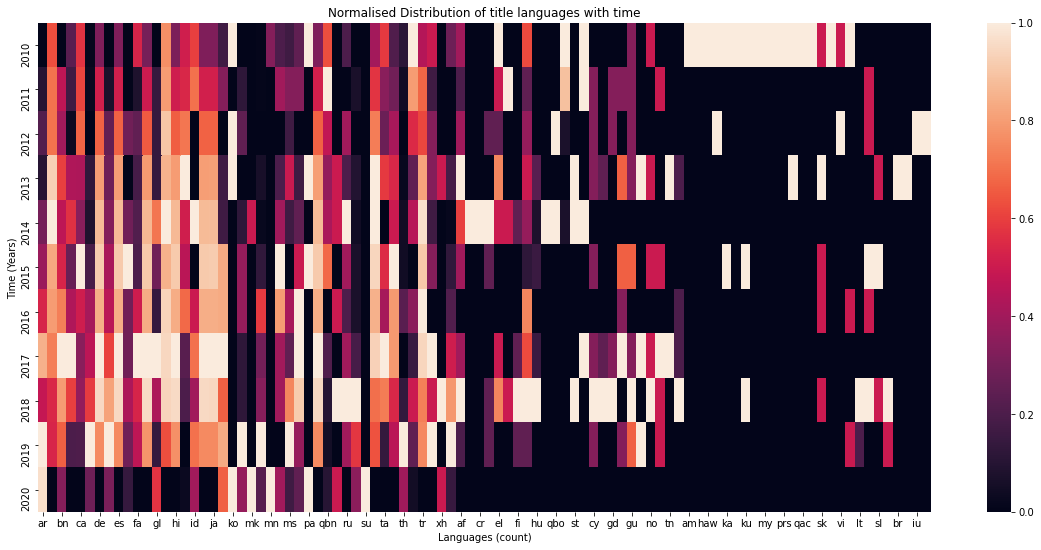

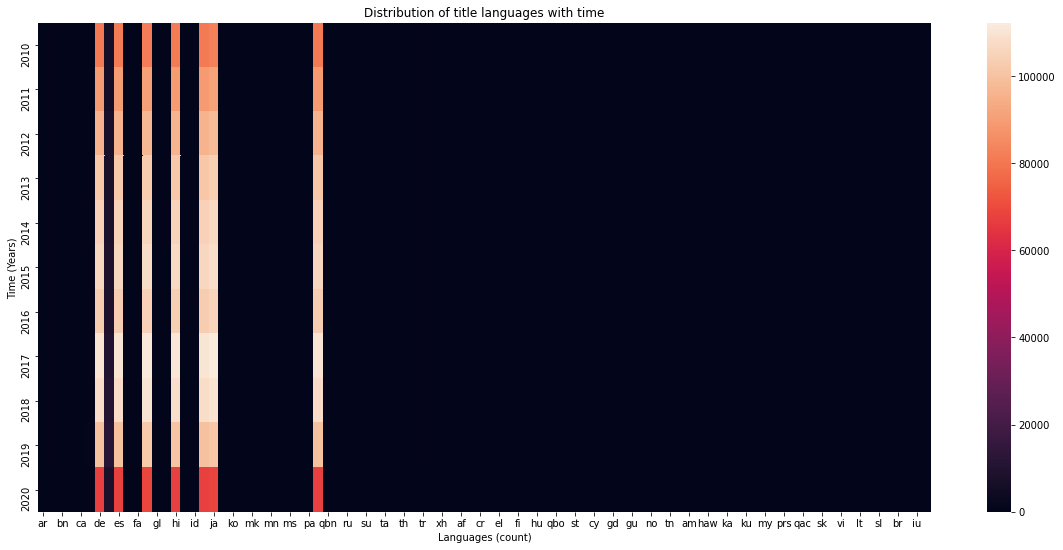

In [25]:
glist= []
# calculate frequency of occurance of each language each year.
for key, value in lang_dist.items():
    u, c = np.unique(value, return_counts=True)
    glist.append(dict(zip(u, c)))

# create pandas distribution with the index being the years
distribution = pd.DataFrame(glist, index=lang_dist.keys()).drop('\\N', axis=1)
distribution.fillna(0, inplace=True)
distribution.sort_index(inplace=True, ascending=True)
# normalise dataset
scaler = MinMaxScaler()
norm_dist = scaler.fit_transform(distribution)
norm_dist = pd.DataFrame(norm_dist, columns=distribution.columns, index=distribution.index)
norm_dist.sort_index(inplace=True, ascending=True)

# plot as heatmaps
plt.figure(figsize=(20, 9))
sns.heatmap(norm_dist)
plt.title("Normalised Distribution of title languages with time")
plt.xlabel("Languages (count)")
plt.ylabel("Time (Years)")

plt.figure(figsize=(20, 9))
sns.heatmap(distribution)
plt.title("Distribution of title languages with time")
plt.xlabel("Languages (count)")
plt.ylabel("Time (Years)")
plt.show()


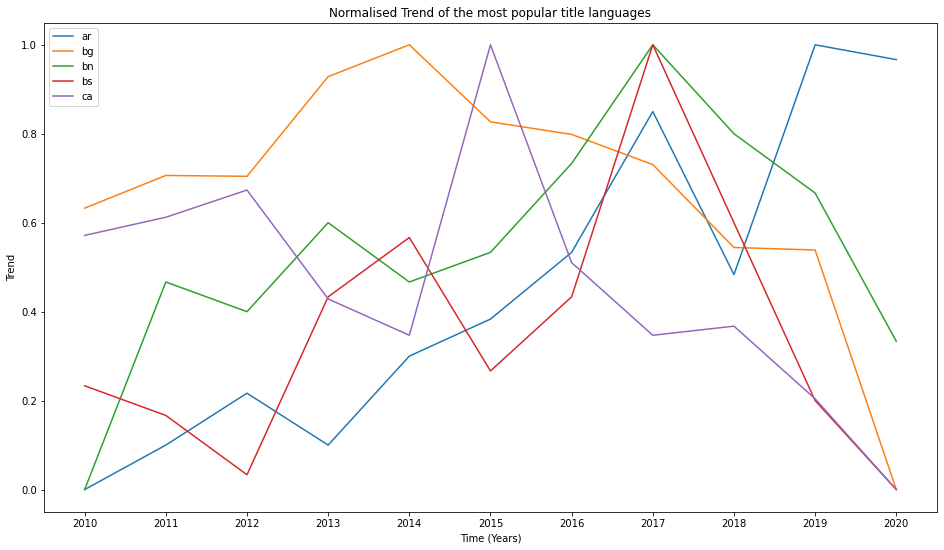

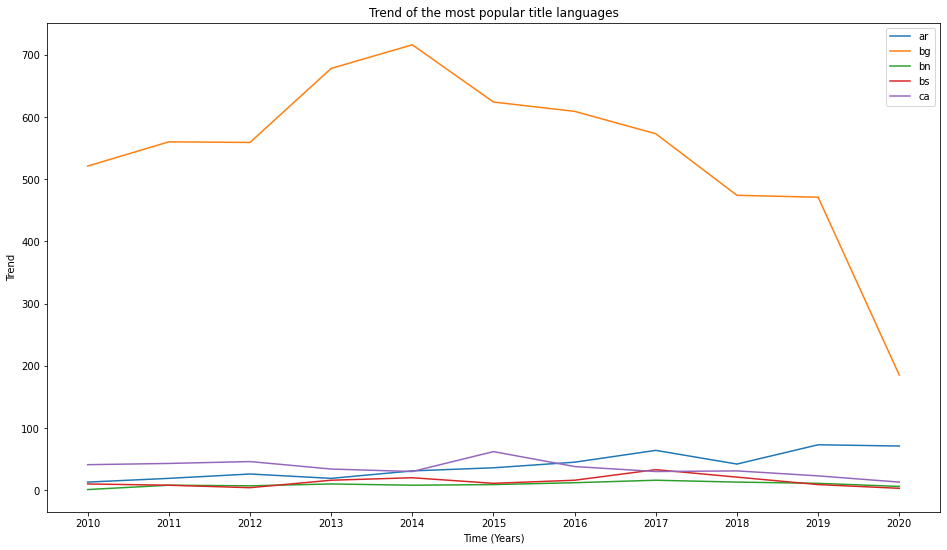

In [26]:

plt.figure(figsize=(16, 9))
# get the 5 most popular languages to plot trends
for column in norm_dist.columns[:5]:
    plt.plot(norm_dist[column], label=column) 
plt.legend()
plt.title("Normalised Trend of the most popular title languages")
plt.xlabel("Time (Years)")
plt.ylabel("Trend")

plt.figure(figsize=(16, 9))
for column in distribution.columns[:5]:
    plt.plot(distribution[column], label=column)
plt.legend()
plt.title("Trend of the most popular title languages")
plt.xlabel("Time (Years)")
plt.ylabel("Trend")
plt.show()

### Generate csv file of the above data

In [24]:
distribution.to_csv("title_languages_distribution.csv")